# Proyecto Final MCAD

* Hazael Alejandro Hinojosa Hernández

Como proyecto final para la materia, el estudiante deberá utilizar el dataset que le haya sido asignado para construir un modelo de predicción que permita generar predicciones respecto a cierta(s) variable(s) de interés. Los datasets y los detalles relacionados con los mismos pueden ser consultados en los enlaces adjunto.

Asignación: Data set *Predict Test Scores of students*

RUBRICAS:
1. Preparación del Dataset (5 puntos)
2. Construcción del Modelo de Predicción (10 puntos)
3. Validación del Modelo de Predicción (5 puntos)
4. Reporte de Proyecto (10 puntos

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Decidi usar el modelo de regresión lineal ya que el lógistico no es el adecuado para este dado que queremos estimar la calificación de los estudiantes a un valor númerico y no a uno de probabilidad si pasaron o no pasaron, el otro posible modelo puede ser el arbol de desciones, pero en esta ocasión solo se realizará el de regresión lineal dados los resultados mostrados en el siguiente proceso

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/test_scores.csv')
display(data.head())
print(data.shape)

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


(2133, 11)


# Preparación del Dataset

Primero quiero saber si hay valores nulos dentros del dataset que deba considerar para eliminar, rellenar o aproximar para realizar su manipulación

In [ ]:
data.isnull().sum()

,0
school,0
school_setting,0
school_type,0
classroom,0
teaching_method,0
n_student,0
student_id,0
gender,0
lunch,0
pretest,0


Preparación del dataset, vamos a pasar las variables categoricas a dummies

In [ ]:
data_clean=data.drop(['school','school_setting','school_type', 'classroom','teaching_method', 'gender', 'lunch',"student_id"],axis=1)
#variables dummy y eliminamos una columna o opción nos quedamos con la 1 en adelante, se elimna la columna 0
dummy_school = pd.get_dummies(data["school"], prefix="school").iloc[:,1:]
dummy_school_setting = pd.get_dummies(data["school_setting"], prefix="school_setting").iloc[:,1:]
dummy_school_type = pd.get_dummies(data["school_type"], prefix="school_type").iloc[:,1:]
dummy_classroom = pd.get_dummies(data["classroom"], prefix="classroom").iloc[:,1:]
dummy_teaching_method = pd.get_dummies(data["teaching_method"], prefix="teaching_method").iloc[:,1:]
dummy_gender = pd.get_dummies(data["gender"], prefix="gender").iloc[:,1:]
dummy_lunch = pd.get_dummies(data["lunch"], prefix="lunch").iloc[:,1:]
data_clean = data_clean.join([dummy_school,dummy_school_setting, dummy_school_type, dummy_classroom,dummy_teaching_method, dummy_gender, dummy_lunch])
data_clean=data_clean.drop(["posttest"],axis=1)
data_clean= data_clean.join(data["posttest"])
data_clean.head()

,n_student,pretest,school_CCAAW,school_CIMBB,school_CUQAM,school_DNQDD,school_FBUMG,school_GJJHK,school_GOKXL,school_GOOBU,...,classroom_XZM,classroom_YTB,classroom_YUC,classroom_ZBH,classroom_ZDT,classroom_ZNS,teaching_method_Standard,gender_Male,lunch_Qualifies for reduced/free lunch,posttest
0,20.0,62.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,72.0
1,20.0,66.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,79.0
2,20.0,64.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,76.0
3,20.0,61.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,77.0
4,20.0,64.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,76.0


Dada la cantidad de columnas obtenidas, se realizará una matriz de correlación para usar solo aquellas con mayor correlación para la creación del modelo

In [ ]:
pd.set_option('display.max_rows', None) #para poder observar todas las variables y su correlacion no solo las primeras y ultimas
correlation_matrix = data_clean.corr()
cor_target = correlation_matrix["posttest"].sort_values(ascending=False)
print(cor_target)

posttest                                  1.000000
pretest                                   0.950884
school_setting_Suburban                   0.454704
school_UKPGS                              0.434771
school_IDGFP                              0.308953
classroom_9AW                             0.202935
classroom_P2A                             0.200691
classroom_08N                             0.190788
school_ZMNYA                              0.189678
school_CCAAW                              0.182682
classroom_98D                             0.177884
school_UUUQX                              0.176066
classroom_V77                             0.171611
classroom_PGH                             0.169015
classroom_IPU                             0.165587
classroom_XXE                             0.156214
classroom_KXB                             0.150697
school_CIMBB                              0.133454
school_FBUMG                              0.122164
classroom_H7S                  

Selección de las columnas predictoras o la target, voy a seleccionar las 10 primeras o que tienen mas correlación según la matriz para las variables predictoras

In [ ]:
pd.reset_option('display.max_rows')
predictors = data_clean[["pretest","school_setting_Suburban", "school_UKPGS","school_IDGFP", "classroom_9AW", "classroom_P2A","classroom_08N", "school_ZMNYA","school_CCAAW", "classroom_98D"]]
target = data_clean["posttest"]
y=target
x=predictors
display(x.head())
display(y.head())


,pretest,school_setting_Suburban,school_UKPGS,school_IDGFP,classroom_9AW,classroom_P2A,classroom_08N,school_ZMNYA,school_CCAAW,classroom_98D
0,62.0,False,False,False,False,False,False,False,False,False
1,66.0,False,False,False,False,False,False,False,False,False
2,64.0,False,False,False,False,False,False,False,False,False
3,61.0,False,False,False,False,False,False,False,False,False
4,64.0,False,False,False,False,False,False,False,False,False


,posttest
0,72.0
1,79.0
2,76.0
3,77.0
4,76.0


# Construcción del modelo de predicción

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(f"conjuntos de prueba {x_test.shape}")
print(f"conjuntos de entrenamiento {x_train.shape}")

conjuntos de prueba (640, 10)
conjuntos de entrenamiento (1493, 10)


In [ ]:
lm = LinearRegression()
lm.fit(x_train, y_train)
print(f"Intercepto: {lm.intercept_}")
print(f"Coeficientes: {lm.coef_}")

Intercepto: 14.846123838836334
Coeficientes: [ 0.94402323 -0.0669391   3.82396391 -0.49949223 -4.56154694  4.530261
 -3.87358539  2.68418824  2.55050901  5.32108699]


# Validación del modelo y de la selección de regresión lineal simple

In [ ]:
R2_train = lm.score(x_train, y_train)
R2_test = lm.score(x_test, y_test)

print(f"oeficiente de determinación R^2 en entrenamiento: {R2_train:.3f}")
print(f"oeficiente de determinación R^2 en testing: {R2_test:.3f}")

oeficiente de determinación R^2 en entrenamiento: 0.906
oeficiente de determinación R^2 en testing: 0.915


In [ ]:
y_pred = lm.predict(x_test)
SSD = np.sum((y_test - y_pred)**2)
RSE = np.sqrt(SSD / (len(y_test) - x_test.shape[1]-1))
Rat=RSE/y_test.mean()
print(f"RSE: {RSE}")
print(f"RSE%: {Rat} %")

RSE: 4.147813344015515
RSE%: 0.06233505236861714 %


In [ ]:
#quiero observar como son los datos que predice el modelo y compararlos con los verdaderos
y_pred = lm.predict(x)
new_table = pd.DataFrame({"posttest_real": data_clean["posttest"],"posttest_predicho": np.round(y_pred).astype(int)}) #np.round(y_pred).astype(int) para redondear al entero dado que asi son las calificaciones
new_table

,posttest_real,posttest_predicho
0,72.0,73
1,79.0,77
2,76.0,75
3,77.0,72
4,76.0,75
...,...,...
2128,55.0,52
2129,46.0,51
2130,51.0,57
2131,53.0,58


Una vez que ya obtuve una estimación y los coeficientes de determinación, se decidió usar corss validation para saber si nuestro modelo depende de la distribución de los datos o es más estable

In [ ]:
cv = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(lm, x, y, scoring='r2', cv=cv)
score_mean = scores.mean()
Errors = 1-scores
Error = Errors.mean()
print("R^2 en cada fold:", scores)
print("R^2 promedio (cross-validation):", score_mean)
print("Error promedio (cross-validation):", Error)

R^2 en cada fold: [0.90795464 0.91512635 0.89530708 0.90179852 0.91861971 0.90604473
 0.90633579 0.8953055  0.90784976 0.92278498]
R^2 promedio (cross-validation): 0.9077127057387585
Error promedio (cross-validation): 0.09228729426124146


Al realizar la validación cruzada podemos observar que el modelo es bastante estable ya que no hay una varianza significativa entre las R^2 de cada fold, también esto indica que no es dependiente de la distribución de los datos y la R^2 es buena (no excelente). Dadas las características anteriores puedo decir que el modelo fabricado es un buen modelo

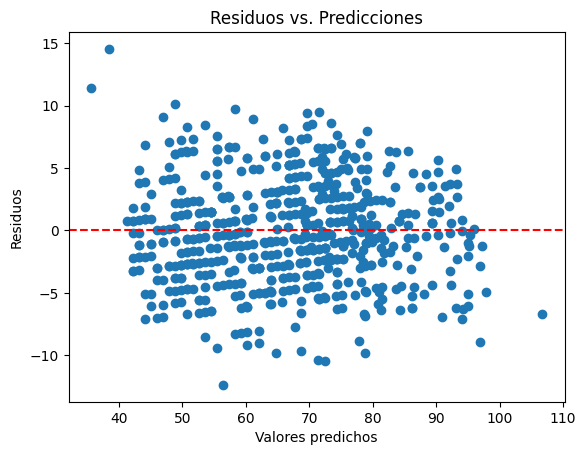

In [ ]:
residuos = y_test - lm.predict(x_test)
plt.scatter(lm.predict(x_test), residuos)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuos vs. Predicciones")
plt.xlabel("Valores predichos")
plt.ylabel("Residuos")
plt.show()

Se realizó una grafica de valores predichos vs residuos para representar el modelo de forma visual. Se puede observar algunos outliers debido a que el modelo no tiene un ajuste perfecto, pero también se puede observar como la mayor parte de los resultados estan en un parametro de +-7.5 lo que no es completamente satisfactorio ya que las calificaciones están en una escala del 0 al 100, pero también es muy importante mencionar que su distribución es uniforme y esto significa que el modelo no tiene un sesgo que diga que tiende más a subestimar o sobreestimar el resultado que es una buena caracteristica.

Se realizó una regreasion lineal de más grados para ver si el ajuste mejora

In [ ]:
def regression_validation(X_data, Y, Y_pred):
    SSD = np.sum((Y - Y_pred) ** 2)
    RSE = np.sqrt(SSD / (len(X_data) - 1))
    y_mean = np.mean(Y)
    RSE_rate = RSE / y_mean
    print("SSD = ", SSD)
    print("RSE = ", RSE)
    print("RSE_% = ", RSE_rate)
    return

for d in range(2, 7):
    poly = PolynomialFeatures(degree=d)
    X_data_poly = poly.fit_transform(x_train)
    lm = LinearRegression()
    lm.fit(X_data_poly, y_train)
    print(f"Regresión de grado: {d}")
    print("R^2 entrenamiento = ", lm.score(X_data_poly, y_train))
    print("R^2 testing = ", lm.score(poly.fit_transform(x_test), y_test))
    print("alpha = ", lm.intercept_)  # Intercepto
    print("beta_i = ", lm.coef_)  # Coeficientes
    y_pred = lm.predict(X_data_poly)
    regression_validation(X_data_poly, y_train, y_pred)
    print("\n")

Regresión de grado: 2
R^2 entrenamiento =  0.9117635059440606
R^2 testing =  0.9195971602809969
alpha =  21.131391868954253
beta_i =  [ 6.72965849e-12  6.44228432e-01  3.55471230e+00  2.90407739e+01
  2.55489018e+01 -5.84357394e+00  1.39602284e+01 -4.94775238e+00
 -8.62718308e-01  6.99702394e+00  7.77119021e+00  3.33229988e-03
 -1.29286145e-01 -1.10722938e+00 -7.43489827e-01  3.29160176e-01
 -3.64833280e-01  2.88319908e-01  7.87962691e-02 -2.80949906e-01
 -2.02067206e-01  3.55471230e+00  2.90407739e+01  0.00000000e+00
 -5.84357394e+00  0.00000000e+00 -4.94775238e+00 -8.62718308e-01
  6.99702394e+00  0.00000000e+00  2.90407739e+01  0.00000000e+00
 -5.84357394e+00  0.00000000e+00 -4.94775238e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.55489018e+01  0.00000000e+00
  1.39602284e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  7.77119021e+00 -5.84357394e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.39602284e+01
  0.00000000e+00  0.0

Se puede observar que no hay un diferencia significativa con el R^2 de entrenamiento y de testing para los grados 2 a 6 e incluso solo hay una diferencia de 0.1 a 0.2 con respecto a la regresión lineal simple realizada anteriormente, por lo que se decidió quedar con los resultados de la regresión lienal simple